In [39]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Input
import time

In [40]:
mnist_images = tf.keras.datasets.mnist.load_data()

In [41]:
train_mnist_images = mnist_images[0][0]
train_mnist_labels = mnist_images[0][1]
test_mnist_images = mnist_images[1][0]
test_mnist_labels = mnist_images[1][1]

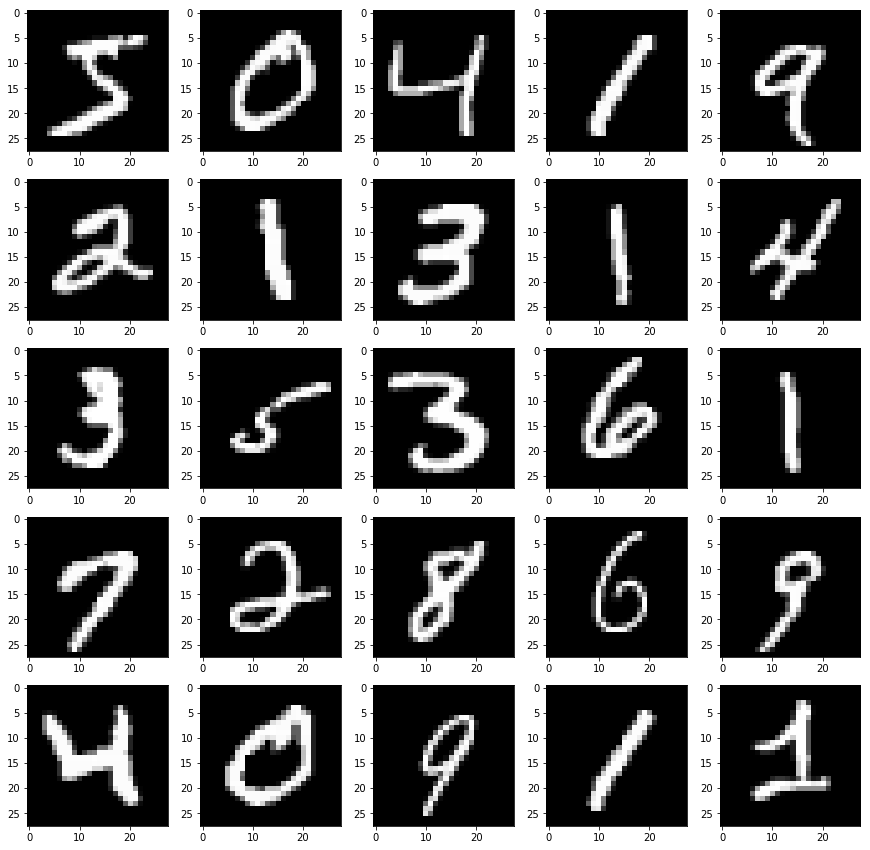

In [42]:
# test  = train_mnist_images[0]
# print (test.shape)
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(15,15))

cnt =0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(train_mnist_images[cnt],cmap='gray')
        cnt = cnt+1
        
        
        
plt.show()

In [43]:
train_mnist_images[0].shape # 28 x 28

(28, 28)

In [44]:
train_mnist_images = train_mnist_images.reshape(train_mnist_images.shape[0], 28, 28, 1).astype('float32')
train_mnist_images = (train_mnist_images - 127.5) / 127.5 
train_mnist_images = train_mnist_images.reshape(train_mnist_images.shape[0],
                                                train_mnist_images.shape[1]*train_mnist_images.shape[2])

In [45]:
noise_dim =100
image_dim = 784
#random_noise = np.random.normal(size=noise_dim)

def generator_model():
    model_gen = Sequential()
    model_gen.add(Dense(50, input_dim=noise_dim))
    model_gen.add(Activation('relu'))
    model_gen.add(Dense(30))
    model_gen.add(Activation('relu'))
    model_gen.add(Dense(50))
    model_gen.add(Activation('relu'))
    model_gen.add(Dense(image_dim,activation='tanh'))
    return model_gen


def discriminator_model():
    model_disc = Sequential()
    model_disc.add(Dense(50, input_shape=(784,)))
    model_disc.add(Activation('relu'))
    model_disc.add(Dense(30))
    model_disc.add(Activation('relu'))
    model_disc.add(Dense(50))
    model_disc.add(Activation('relu'))
    #model_disc.add(Flatten())
    model_disc.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model_disc.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model_disc 

model_test = discriminator_model()
model_test.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_19 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 30)                1530      
_________________________________________________________________
activation_20 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                1550      
_________________________________________________________________
activation_21 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total para

In [46]:
np.random.normal(size=(4,3))

array([[-0.30836978, -0.05343122, -0.32816509],
       [-0.01698864, -0.21532084,  1.07127455],
       [-0.7432719 ,  0.95253914,  0.95525497],
       [ 0.11976293, -1.68907428, -1.44999801]])

In [52]:
#adversarial training

def adversarial_training(G, D):
    D.trainable = False
    noise_vec = Input(shape=(noise_dim,))
    g_z = G(noise_vec)
    d_g_z = D(g_z)
    gan = Model(noise_vec,d_g_z)
    opt = Adam(lr=0.1)
    gan.compile(loss='binary_crossentropy',optimizer = opt , metrics = ['accuracy'])
    return gan



G = generator_model()
D = discriminator_model()

gan = adversarial_training(G,D)
    
print (D.metrics_names)
print (gan.metrics_names)

['loss', 'acc']
['loss', 'acc']


In [48]:
import numpy as np
np.random.randint(0, 10, 4)

array([3, 6, 0, 2])

In [53]:
####GAN algo

loss_gen_final =[]
loss_disc_final =[]
eps =[]
def train_the_GAN(epochs,batch_size,image_data):
    #pass
    for i in range(epochs):
        random_noise = np.random.normal(0,1,size=(batch_size,noise_dim))
        fake_images = G.predict(random_noise)
        #print (type(fake_images))
        tr_idx = np.random.randint(0, image_data.shape[0], batch_size) #revisit
        imgs = image_data[tr_idx]
        #print (len(imgs))
        #print (imgs.shape)
        #print (fake_images.shape)
        data_overall = np.concatenate((imgs,fake_images))
        
        labels_real = np.ones(batch_size)
        labels_fake = np.zeros(batch_size)
        labels_overall = np.concatenate((labels_real,labels_fake))
        
        D.trainable = True
        
        D.train_on_batch(data_overall,labels_overall)
        
        loss_disc = D.evaluate(data_overall,labels_overall,verbose=0) 
        
        
        
        
        random_noise = np.random.normal(size=(batch_size,noise_dim))
        labels_gen =np.ones(batch_size)
        
        D.trainable = False
        gan.train_on_batch(random_noise,labels_gen)
        
        loss_gen = gan.evaluate(random_noise,labels_gen,verbose=0)
        
        if (i+1)%20 ==0:
            
            loss_disc_final.append(loss_disc)
            loss_gen_final.append(loss_gen)
        
        #eps.append(epochs)
        
        
        if (i+1)%10:
            
            print ("Epoch= ", i+1, end =' ')
            print (" Discriminator Loss = %0.3f" %loss_disc[0], end =' ')
            print (" Discriminator Accuracy = %0.3f" %loss_disc[1], end =' ')
            print (" Generator Loss = %0.3f" %loss_gen[0], end = ' ')
            print (" Generator Accuracy = %0.3f" %loss_gen[1])
            
        
    return loss_disc_final,loss_gen_final,eps
        
        
        
        
    
    
loss_disc, loss_gen,epochs = train_the_GAN(1000,200,train_mnist_images)

#print (test_mod)
        
        
        
        
        
        
        
        

Epoch=  1  Discriminator Loss = 0.793  Discriminator Accuracy = 0.542  Generator Loss = 0.184  Generator Accuracy = 1.000
Epoch=  2  Discriminator Loss = 1.209  Discriminator Accuracy = 0.128  Generator Loss = 0.108  Generator Accuracy = 1.000
Epoch=  3  Discriminator Loss = 1.390  Discriminator Accuracy = 0.223  Generator Loss = 0.124  Generator Accuracy = 1.000
Epoch=  4  Discriminator Loss = 1.280  Discriminator Accuracy = 0.367  Generator Loss = 0.150  Generator Accuracy = 1.000
Epoch=  5  Discriminator Loss = 1.162  Discriminator Accuracy = 0.417  Generator Loss = 0.177  Generator Accuracy = 1.000
Epoch=  6  Discriminator Loss = 1.060  Discriminator Accuracy = 0.480  Generator Loss = 0.215  Generator Accuracy = 1.000
Epoch=  7  Discriminator Loss = 0.949  Discriminator Accuracy = 0.495  Generator Loss = 0.258  Generator Accuracy = 1.000
Epoch=  8  Discriminator Loss = 0.851  Discriminator Accuracy = 0.495  Generator Loss = 0.320  Generator Accuracy = 1.000
Epoch=  9  Discriminator

Epoch=  77  Discriminator Loss = 0.012  Discriminator Accuracy = 1.000  Generator Loss = 4.235  Generator Accuracy = 0.000
Epoch=  78  Discriminator Loss = 0.012  Discriminator Accuracy = 1.000  Generator Loss = 4.259  Generator Accuracy = 0.000
Epoch=  79  Discriminator Loss = 0.011  Discriminator Accuracy = 1.000  Generator Loss = 4.283  Generator Accuracy = 0.000
Epoch=  81  Discriminator Loss = 0.010  Discriminator Accuracy = 1.000  Generator Loss = 4.331  Generator Accuracy = 0.000
Epoch=  82  Discriminator Loss = 0.010  Discriminator Accuracy = 1.000  Generator Loss = 4.354  Generator Accuracy = 0.000
Epoch=  83  Discriminator Loss = 0.010  Discriminator Accuracy = 1.000  Generator Loss = 4.377  Generator Accuracy = 0.000
Epoch=  84  Discriminator Loss = 0.010  Discriminator Accuracy = 1.000  Generator Loss = 4.400  Generator Accuracy = 0.000
Epoch=  85  Discriminator Loss = 0.009  Discriminator Accuracy = 1.000  Generator Loss = 4.422  Generator Accuracy = 0.000
Epoch=  86  Disc

Epoch=  154  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.565  Generator Accuracy = 0.000
Epoch=  155  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.578  Generator Accuracy = 0.000
Epoch=  156  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.590  Generator Accuracy = 0.000
Epoch=  157  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.602  Generator Accuracy = 0.000
Epoch=  158  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.615  Generator Accuracy = 0.000
Epoch=  159  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.627  Generator Accuracy = 0.000
Epoch=  161  Discriminator Loss = 0.003  Discriminator Accuracy = 1.000  Generator Loss = 5.651  Generator Accuracy = 0.000
Epoch=  162  Discriminator Loss = 0.002  Discriminator Accuracy = 1.000  Generator Loss = 5.663  Generator Accuracy = 0.000
Epoch=  

Epoch=  231  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.350  Generator Accuracy = 0.000
Epoch=  232  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.358  Generator Accuracy = 0.000
Epoch=  233  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.366  Generator Accuracy = 0.000
Epoch=  234  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.374  Generator Accuracy = 0.000
Epoch=  235  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.383  Generator Accuracy = 0.000
Epoch=  236  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.391  Generator Accuracy = 0.000
Epoch=  237  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.399  Generator Accuracy = 0.000
Epoch=  238  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.407  Generator Accuracy = 0.000
Epoch=  

Epoch=  307  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.898  Generator Accuracy = 0.000
Epoch=  308  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.905  Generator Accuracy = 0.000
Epoch=  309  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.911  Generator Accuracy = 0.000
Epoch=  311  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.923  Generator Accuracy = 0.000
Epoch=  312  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.929  Generator Accuracy = 0.000
Epoch=  313  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.936  Generator Accuracy = 0.000
Epoch=  314  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.942  Generator Accuracy = 0.000
Epoch=  315  Discriminator Loss = 0.001  Discriminator Accuracy = 1.000  Generator Loss = 6.948  Generator Accuracy = 0.000
Epoch=  

Epoch=  384  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.342  Generator Accuracy = 0.000
Epoch=  385  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.349  Generator Accuracy = 0.000
Epoch=  386  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.355  Generator Accuracy = 0.000
Epoch=  387  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.362  Generator Accuracy = 0.000
Epoch=  388  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.369  Generator Accuracy = 0.000
Epoch=  389  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.375  Generator Accuracy = 0.000
Epoch=  391  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.388  Generator Accuracy = 0.000
Epoch=  392  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.395  Generator Accuracy = 0.000
Epoch=  

Epoch=  461  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.786  Generator Accuracy = 0.000
Epoch=  462  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.791  Generator Accuracy = 0.000
Epoch=  463  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.796  Generator Accuracy = 0.000
Epoch=  464  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.801  Generator Accuracy = 0.000
Epoch=  465  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.806  Generator Accuracy = 0.000
Epoch=  466  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.811  Generator Accuracy = 0.000
Epoch=  467  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.816  Generator Accuracy = 0.000
Epoch=  468  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 7.820  Generator Accuracy = 0.000
Epoch=  

Epoch=  537  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.128  Generator Accuracy = 0.000
Epoch=  538  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.132  Generator Accuracy = 0.000
Epoch=  539  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.136  Generator Accuracy = 0.000
Epoch=  541  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.145  Generator Accuracy = 0.000
Epoch=  542  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.148  Generator Accuracy = 0.000
Epoch=  543  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.152  Generator Accuracy = 0.000
Epoch=  544  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.156  Generator Accuracy = 0.000
Epoch=  545  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.160  Generator Accuracy = 0.000
Epoch=  

Epoch=  614  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.414  Generator Accuracy = 0.000
Epoch=  615  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.417  Generator Accuracy = 0.000
Epoch=  616  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.420  Generator Accuracy = 0.000
Epoch=  617  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.424  Generator Accuracy = 0.000
Epoch=  618  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.427  Generator Accuracy = 0.000
Epoch=  619  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.431  Generator Accuracy = 0.000
Epoch=  621  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.437  Generator Accuracy = 0.000
Epoch=  622  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.440  Generator Accuracy = 0.000
Epoch=  

Epoch=  691  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.658  Generator Accuracy = 0.000
Epoch=  692  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.660  Generator Accuracy = 0.000
Epoch=  693  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.663  Generator Accuracy = 0.000
Epoch=  694  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.667  Generator Accuracy = 0.000
Epoch=  695  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.669  Generator Accuracy = 0.000
Epoch=  696  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.672  Generator Accuracy = 0.000
Epoch=  697  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.676  Generator Accuracy = 0.000
Epoch=  698  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.678  Generator Accuracy = 0.000
Epoch=  

Epoch=  767  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.871  Generator Accuracy = 0.000
Epoch=  768  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.873  Generator Accuracy = 0.000
Epoch=  769  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.876  Generator Accuracy = 0.000
Epoch=  771  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.881  Generator Accuracy = 0.000
Epoch=  772  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.884  Generator Accuracy = 0.000
Epoch=  773  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.886  Generator Accuracy = 0.000
Epoch=  774  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.889  Generator Accuracy = 0.000
Epoch=  775  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 8.892  Generator Accuracy = 0.000
Epoch=  

Epoch=  844  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.065  Generator Accuracy = 0.000
Epoch=  845  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.067  Generator Accuracy = 0.000
Epoch=  846  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.069  Generator Accuracy = 0.000
Epoch=  847  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.072  Generator Accuracy = 0.000
Epoch=  848  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.074  Generator Accuracy = 0.000
Epoch=  849  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.076  Generator Accuracy = 0.000
Epoch=  851  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.081  Generator Accuracy = 0.000
Epoch=  852  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.083  Generator Accuracy = 0.000
Epoch=  

Epoch=  921  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.241  Generator Accuracy = 0.000
Epoch=  922  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.243  Generator Accuracy = 0.000
Epoch=  923  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.246  Generator Accuracy = 0.000
Epoch=  924  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.248  Generator Accuracy = 0.000
Epoch=  925  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.250  Generator Accuracy = 0.000
Epoch=  926  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.252  Generator Accuracy = 0.000
Epoch=  927  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.254  Generator Accuracy = 0.000
Epoch=  928  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.256  Generator Accuracy = 0.000
Epoch=  

Epoch=  997  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.401  Generator Accuracy = 0.000
Epoch=  998  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.403  Generator Accuracy = 0.000
Epoch=  999  Discriminator Loss = 0.000  Discriminator Accuracy = 1.000  Generator Loss = 9.406  Generator Accuracy = 0.000


50


/home/wenqi/anaconda2/envs/RL/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


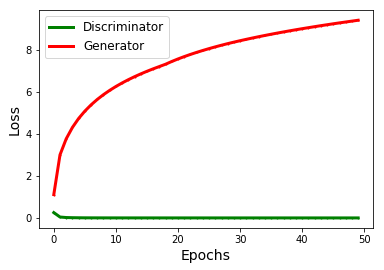

In [54]:
import matplotlib.pyplot as plt

D_loss = []
G_loss = []


for i,j in zip(loss_disc,loss_gen):
    
    D_loss.append(i[0])
    G_loss.append(j[0])
    
epochs = range(len(D_loss)) 
print(len(D_loss))
plt.plot(epochs,D_loss,color="green",linewidth =3, marker ="o",markerfacecolor="green",markersize=1,label ='Discriminator')
plt.plot(epochs,G_loss,color="red",linewidth =3, marker ="o",markerfacecolor="red",markersize=1,label ='Generator')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(loc='top right',fontsize=12)               
    

    
    



In [65]:
!nvidia-smi

Sat Nov  2 16:14:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.09       Driver Version: 430.09       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0  On |                  N/A |
| 29%   52C    P2    60W / 250W |  10765MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!sudo kill -9 22258// sudo kill -9 22258

[sudo] password for wenqi: 

In [34]:
print ("Epoch= %2.3f"% 2.6543)

Epoch= 2.654


In [38]:
print ("Epoch= ", 1, end =' ')
print (" Loss of Discriminator = %5.3f" %2.6543, end =' ')
print (" Accuracy of Discriminator = %5.3f" %65, end =' ')
print (" Loss of Generator = %5.3f" %2.6543, end = ' ')
print (" Accuracy of Generator = %5.3f" %45)

Epoch=  1  Loss of Discriminator = 2.654  Accuracy of Discriminator = 65.000  Loss of Generator = 2.654  Accuracy of Generator = 45.000 